# GLMsingle: single-trial estimation in rapid event-related design

This notebook is my attempt at applying the new GLMsingle toolbox to the SVD dataset. I am starting with the tutorial provided on the GLMsingle GitHub and modifying it for the SVD dataset. (LM)
https://htmlpreview.github.io/?https://github.com/kendrickkay/GLMsingle/blob/main/examples/example1.html   

By default, the tool implements a set of optimizations that improve upon generic GLM approaches by: (1) identifying an optimal hemodynamic response function (HRF) at each voxel, (2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and picking an optimal number to include in the final GLM, and (3) applying a custom amount of ridge regularization at each voxel using an efficient technique called "fracridge". The output of GLMsingle are GLM betas reflecting the estimated percent signal change in each voxel in response to each experimental stimulus or condition being modeled.

Example 1 contains a full walkthrough of the process of loading an example dataset and design matrix, estimating neural responses using GLMsingle, estimating the reliability of responses at each voxel, and comparing those achieved via GLMsingle to those achieved using a baseline GLM. After loading and visualizing formatted fMRI time-series and their corresponding design matrices, we will describe the default behavior of GLMsingle and show how to modify hyperparameters if the user desires. Throughout the notebook we will highlight important metrics and outputs using figures, print statements, and comments.

## A note about conda environments

When running this notebook, make sure you have activated the mindeye conda environment.

## Define settings

What subject and session do you want to run? 

In [1]:
sub = 'sub-001'
session = 'ses-01'

if session == 'all':
    session_list = ['ses-01', 'ses-02']
    # task_list = ['study','study','study','study','study','study',
    #              'postscenes', 'familiarization', 'familiarization',
    #              'reward', 'reward','reward','reward','postfaces'] #decision runs not included
    # run_list = [1,2,3,4,5,6,1,1,2,1,2,3,4,1]
    # session_indicator = [1,1,1,1,1,1,2,2,2,2,2,2,2,2]
    # n_runs = 6+1+2+4+1
else:
    task='study'
    if sub=='sub-002':
        n_runs=9
    else:
        n_runs=16 #session 1 runs

##### Do you want to intersect brain masks from each run to create an average mask? If avg_mask already exists, set this to 0.

In [2]:
make_avg_mask = 0

Do you want to load the raw 4D data and run the time-intensive NiftiMasker? 
If the 2D data already exist, set this to 0.

In [3]:
load_epi = 0

##### Do you need to upsample the fMRI data? If the upsampled data already exists, set this to 0.

In [4]:
run_upsampling = 0

Do you want to export design matrix to csv? 

In [5]:
export_csv = 0

Do you want to run GLMsingle? If you want to load existing GLMsingle outputs, set this to 0.

In [6]:
run_glmsingle = 0
run_glmbaseline = 0

Do you want to run reliability calculations?

In [7]:
run_reliability = 1

## Import necessary packages

In [8]:
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import imagestats
import nilearn
from nilearn.input_data import NiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import h5py

import glmsingle
from glmsingle.glmsingle import GLM_single

%matplotlib inline 
%autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/usr/people/ps6938/miniconda3/envs/pygers/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/usr/people/ps6938/miniconda3/envs/pygers/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Autosaving every 5 seconds


## Set paths and load settings

In [9]:
example = 0
stimdur = 3
tr_orig=1.5
tr=1 #after upsampling

In [10]:
# bids directory
homedir = '/jukebox/norman/pscotti/rtmindeye/data/bids'

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub)
maskdir = join(homedir,'derivatives','masks', sub)
designdir = '/jukebox/norman/pscotti/rtmindeye/data/design/'
outputdir = join(homedir,'derivatives','glmsingle/')
ses1_dir = join(datadir,f'{session}','func/')
defaced_dir = join(homedir,'derivatives','deface/')

# make a directory for this subject
path = os.path.join(outputdir,sub)
os.makedirs(path,exist_ok=True)
os.makedirs(maskdir,exist_ok=True)

print(f'directory to load preprocessed data from:\n\t{datadir}\n')
print(f'directory to save outputs:\n\t{path}\n')

directory to load preprocessed data from:
	/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/fmriprep/sub-001

directory to save outputs:
	/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001



I ran into an issue because of my small voxels, I have more than 1,000,000 "voxels" in my brain images (including voxels outside the brain).

I'm going to use NiftiMasker to apply the average brain mask to data, then instead of passing 4D (XYZT) images to data array, pass 2D (units x time) to data array.

## Load this subject's design matrix
design is in the format design[run] rows are timepoints, columns are distinct images

In [11]:
filename = f"{designdir}csv/{sub}.csv"
print(filename)
data = pd.read_csv(filename)
images = data['current_image'].values[23:]
starts = data['trial.started'].values[23:]
is_new_run = data['is_new_run'].values[23:]

unique_images = np.unique(images.astype(str))
len_unique_images = len(unique_images)
print("len_unique_images",len_unique_images)
print("n_runs",n_runs)

print(images[:4])
print(starts[:4])
print(is_new_run[:4])

/jukebox/norman/pscotti/rtmindeye/data/design/csv/sub-001.csv
len_unique_images 851
n_runs 16
['images/image_686_seed_1.png' 'images/image_262_seed_1.png'
 'images/image_508_seed_1.png' 'images/image_671_seed_1.png']
[742.49907775 746.4931488  750.48907224 754.489129  ]
[0. 0. 0. 0.]


In [12]:
design = [np.zeros((288, len_unique_images)) for _ in range(n_runs)]
starting_time = starts[0]
cur_run = 0
end_of_run = False
print(f"run = {cur_run}")
for i in range(len(images)-1):
    if is_new_run[i] == 1:
        end_of_run = True
        continue
        
    if end_of_run:
        starting_time = starts[i] - 1 # because of 1-sec delay before image presentation
        cur_run += 1
        print(f"run = {cur_run}")
        end_of_run = False
        
    if images[i] == "blank.jpg":
        continue

    image_idx = np.where(images[i]==unique_images)[0].item()
    timepoint = int(np.round(starts[i] - starting_time))
    # print(timepoint, image_idx)
    design[cur_run][timepoint, image_idx] = 1

run = 0
run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12
run = 13
run = 14
run = 15


In [13]:
# from copy import deepcopy
# newdesign = deepcopy(design)

# # Plot design matrix for each run
# run=15
# plt.figure(figsize=(6,6))
# plt.imshow(newdesign[run][:10,:10],interpolation='none')
# plt.title(' design matrix from run %i' %(run+1), fontsize=16)
# plt.xlabel('conditions',fontsize=16)
# plt.ylabel('time (TR)',fontsize=16) 

# # Plot design matrix for each run
# run=15
# plt.figure(figsize=(6,6))
# plt.imshow(design[run][:10,:10],interpolation='none')
# plt.title(' design matrix from run %i' %(run+1), fontsize=16)
# plt.xlabel('conditions',fontsize=16)
# plt.ylabel('time (TR)',fontsize=16) 

## Create a brain mask that intersects each run's brain mask from fMRIPrep

From GLMSingle FAQ: The safest approach is to completely zero out the data for a voxel that does not have full data for all of the runs that you are analyzing with GLMsingle.

Loading average brain mask: /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/masks/sub-001/sub-001_ses-01_brain.nii.gz

Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[   2.     0.     0.   -73.5]
 [   0.     2.     0.  -109. ]
 [   0.     0.     2.   -57. ]
 [   0.     0.     0.     1. ]]

There are 165240.0 voxels in the included brain mask



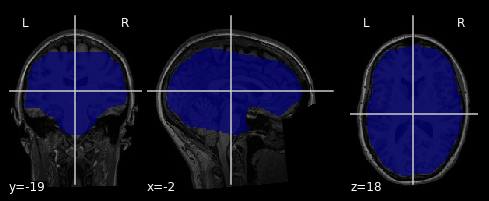

In [14]:
if make_avg_mask == 1:
    mask_imgs=[]
    for run in range(1,n_runs+1):
        if run < 10:
            mask_name = ses1_dir + sub + '_ses-01_task-study_run-0%i_space-T1w_desc-brain_mask.nii.gz' % run
        else:
            mask_name = ses1_dir + sub + '_ses-01_task-study_run-%i_space-T1w_desc-brain_mask.nii.gz' % run
        mask_imgs.append(mask_name)
    
    # intersect all session 1 brain masks    
    avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

    # Save the mask
    dimsize=avg_mask.header.get_zooms()
    affine_mat = avg_mask.affine
    hdr = avg_mask.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
    output_name = maskdir + '/%s_%s_brain.nii.gz' % (sub, session)
    print('Save average mask:', output_name)
    nib.save(avg_mask, output_name)
    print('')
    
elif make_avg_mask == 0:
    #Load brain mask
    file_in = maskdir + '/%s_%s_brain.nii.gz' % (sub, session)
    print('Loading average brain mask:', file_in)
    print('')
    avg_mask=nib.load(file_in)

# plot
t1_file = defaced_dir + sub + '_ses-01_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file)
plot_roi(avg_mask, bg_img=t1_img)

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

## Apply mask to each run of functional data
Data will go from 4D (x,y,z,t) to 2D

In [15]:
# get some info about epi data by loading study run 1
epi_file=datadir + '/ses-01/func/%s_ses-01_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz' % (sub)
epi_data=nib.load(epi_file)
run1=epi_data.get_fdata()

print('checking epi data for run 1:', epi_file)
print('')
epi_dimsize=epi_data.header.get_zooms()
epi_affine=epi_data.affine
print('Dimensions:', epi_dimsize)
print('Affine:')
print(epi_data.affine)
print('')

# get shape of data volume (XYZ) for convenience
xyz = run1.shape[:3]
xyzt = run1.shape
print(xyz)
print(xyzt)

# double check that brain mask and epi data have same dimensions and affine
assert avg_mask.header.get_zooms() == epi_dimsize[:3]
assert avg_mask.affine.all() == epi_data.affine.all()

checking epi data for run 1: /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/fmriprep/sub-001/ses-01/func/sub-001_ses-01_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (2.0, 2.0, 2.0, 1.5)
Affine:
[[   2.     0.     0.   -73.5]
 [   0.     2.     0.  -109. ]
 [   0.     0.     2.   -57. ]
 [   0.     0.     0.     1. ]]

(72, 94, 71)
(72, 94, 71, 192)


In [16]:
# variables that will contain bold time-series and design matrices from each run
data = []
TR_run = []

if load_epi == 1:
    epi_masker=NiftiMasker(mask_img=avg_mask)

    for run in range(0,n_runs):
        if run < 9:
            epi_file=datadir + '/%s/func/%s_%s_task-study_run-0%i_space-T1w_desc-preproc_bold.nii.gz' % (session,sub,session,run+1)
        else:
            epi_file=datadir + '/%s/func/%s_%s_task-study_run-%i_space-T1w_desc-preproc_bold.nii.gz' % (session,sub,session,run+1)
    
        print('loading data for run', run+1, ':', epi_file)
        #print(run,ses,task,rr)
        print('')
        epi_mask_data = epi_masker.fit_transform(epi_file)
    
        # alternate to NiftiMasker
        # from nilearn.masking import apply_mask
        # masked_data = apply_mask(epi_file, mask_img)
    
        epi_mask_data = epi_mask_data.T #transpose to make it voxels,time
        #print('epi data shape:', epi_mask_data.shape)

        # add this run's data to data variable
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])
        print('BOLD data shape:', data[run].shape)
        print('TRs in this run:', TR_run[run])
        
        # save individual run data to npy file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_bold' %(sub,session,run+1))
        print(f'\n*** Saving data to {filename} ***\n')
        np.save(filename, epi_mask_data)

elif load_epi == 0:
    for run in range(0,n_runs):        
        
        # load npy data file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_bold.npy' %(sub,session,run+1))
        print(f'\n*** Loading data from {filename} ***\n')
        epi_mask_data = np.load(filename)
        
        # add this run's data to data variable
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])
        
        print('BOLD data shape:', data[run].shape)
        print('TRs in this run:', TR_run[run])
        
print('')
print('number of runs in BOLD data:', len(data))  


*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-01_2D_bold.npy ***

BOLD data shape: (165240, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-02_2D_bold.npy ***

BOLD data shape: (165240, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-03_2D_bold.npy ***

BOLD data shape: (165240, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-04_2D_bold.npy ***

BOLD data shape: (165240, 192)
TRs in this run: 192

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-05_2D_bold.npy ***

BOLD data shape: (165240, 192)
TRs in this run: 192

*** 

## Upsample fMRI data to 1-sec TR
At this point, we have extracted all brain voxels and flattened the data to 2D (voxels,TR). 
Now we will interpolate the time-series to go from 1.5 sec TR to 1 sec TR. 

In [17]:
from tseriesinterp import *

# import importlib
# import tseriesinterp #import the module here, so that it can be reloaded.
# importlib.reload(tseriesinterp)
# from tseriesinterp import * # or whatever name you want.

In [18]:
# Upsample one run as an example
data_upsampled = tseriesinterp(data[0], 1.5, 1, dim=1)
data_upsampled.shape

(165240, 288)

Text(0, 0.5, 'Voxel Intensity')

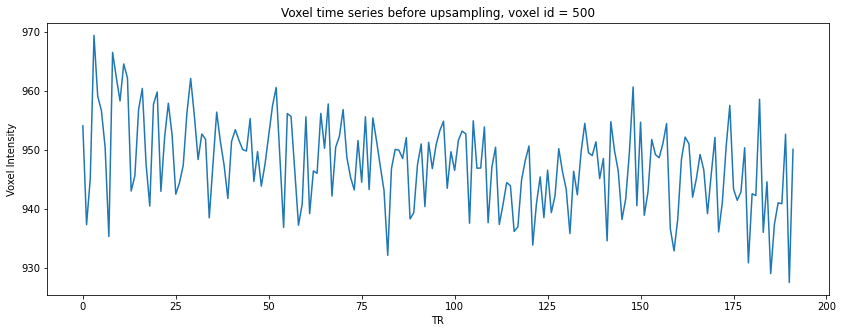

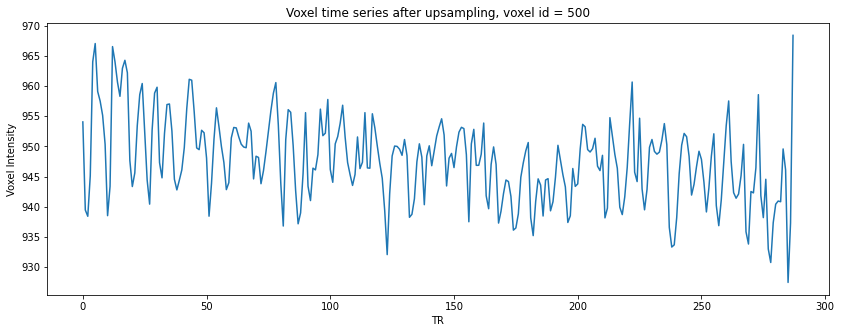

In [19]:
voxel_id=500

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(data[0][voxel_id, :])
ax.set_title('Voxel time series before upsampling, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(data_upsampled[voxel_id, :])
ax.set_title('Voxel time series after upsampling, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')


In [20]:
data_upsampled = []
TR_run_upsampled = []

if run_upsampling == 1:
    
    for run in range(0,n_runs): 
        # perform interpolation
        data_new = tseriesinterp(data[run], tr_orig, tr, dim=1)
    
        # add this run's data to data variable
        data_upsampled.append(data_new)
        TR_run_upsampled.append(data_new.shape[1])
            
        print('BOLD data shape:', data_upsampled[run].shape)
        print('TRs in this run:', TR_run_upsampled[run])
    
        # save individual run data to npy file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_upsampled_bold' %(sub,session,run+1))
        print(f'\n*** Saving data to {filename} ***\n')
        np.save(filename, data_new)

elif run_upsampling == 0:
    
    for run in range(0,n_runs):        
        # load npy data file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_upsampled_bold.npy' %(sub,session,run+1))
        print(f'\n*** Loading data from {filename} ***\n')
        data_new = np.load(filename)
        
        # add this run's data to data variable
        data_upsampled.append(data_new)
        TR_run_upsampled.append(data_new.shape[1])
        
        print('BOLD data shape:', data_upsampled[run].shape)
        print('TRs in this run:', TR_run_upsampled[run])
            
print('')
print('number of runs in upsampled BOLD data:', len(data_upsampled))   


*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-01_2D_upsampled_bold.npy ***

BOLD data shape: (165240, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-02_2D_upsampled_bold.npy ***

BOLD data shape: (165240, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-03_2D_upsampled_bold.npy ***

BOLD data shape: (165240, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-04_2D_upsampled_bold.npy ***

BOLD data shape: (165240, 288)
TRs in this run: 288

*** Loading data from /jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/sub-001_ses-01_task-study_run-05_2D_upsampled_bold.npy ***

BOLD da

In [21]:
# print some relevant metadata
print(f'There are {len(data_upsampled)} runs in total\n')
#print(f'N = {data[0].shape[1]} TRs per run\n')
print(f'XYZ dimensionality is: {xyz}\n')
print(f'The dimensions of the 2D data for each run are:\n {data_upsampled[0].shape}\n {data_upsampled[1].shape}\n {data_upsampled[2].shape}') 
print(f' {data_upsampled[3].shape}\n {data_upsampled[4].shape}\n {data_upsampled[5].shape}\n {data_upsampled[6].shape}\n {data_upsampled[7].shape}')
print(f'The stimulus duration is {stimdur} seconds\n')
print(f'The TR is {tr} seconds\n')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')
#print(f'There are {np.sum(roi)} voxels in the included visual ROI\n')
print(f'Numeric precision of data is: {type(data[0][0,0])}\n')


There are 16 runs in total

XYZ dimensionality is: (72, 94, 71)

The dimensions of the 2D data for each run are:
 (165240, 288)
 (165240, 288)
 (165240, 288)
 (165240, 288)
 (165240, 288)
 (165240, 288)
 (165240, 288)
 (165240, 288)
The stimulus duration is 3 seconds

The TR is 1 seconds

There are 165240.0 voxels in the included brain mask

Numeric precision of data is: <class 'numpy.float64'>



Text(0.5, 1.0, 'example slice from run 9')

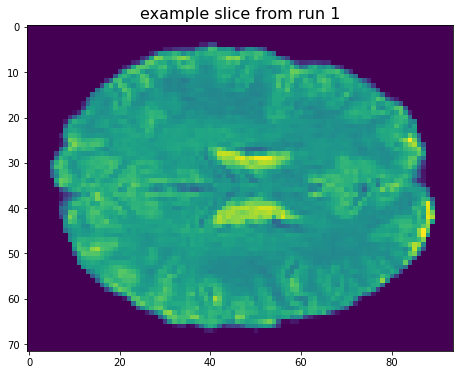

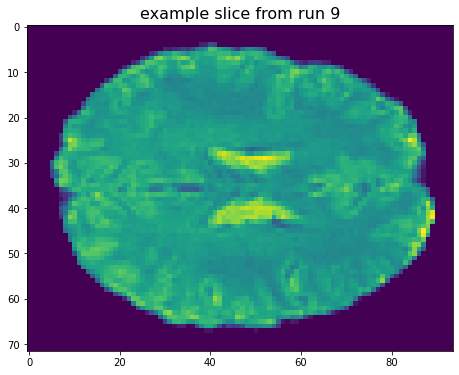

In [22]:
# plot example slice from run 1 and run 16
# first, we need to unmask the data to get it back into 3D/4D format:
X = nilearn.masking.unmask(data_upsampled[0].T, avg_mask)
run1 = X.get_fdata()

X = nilearn.masking.unmask(data_upsampled[8].T, avg_mask)
run16 = X.get_fdata()

z=45
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run1[:,:,z,0])
plt.title('example slice from run 1',fontsize=16)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run16[:,:,z,0])
plt.title('example slice from run 9',fontsize=16)

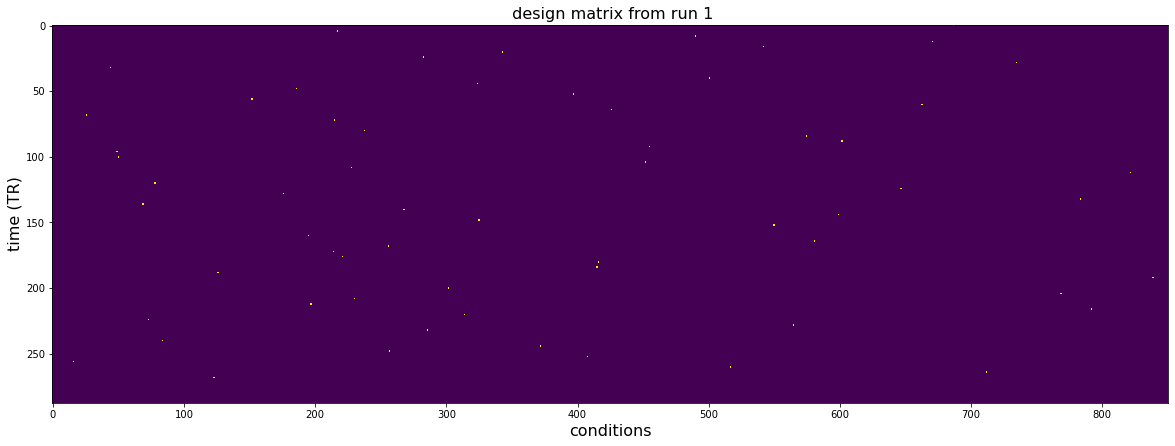

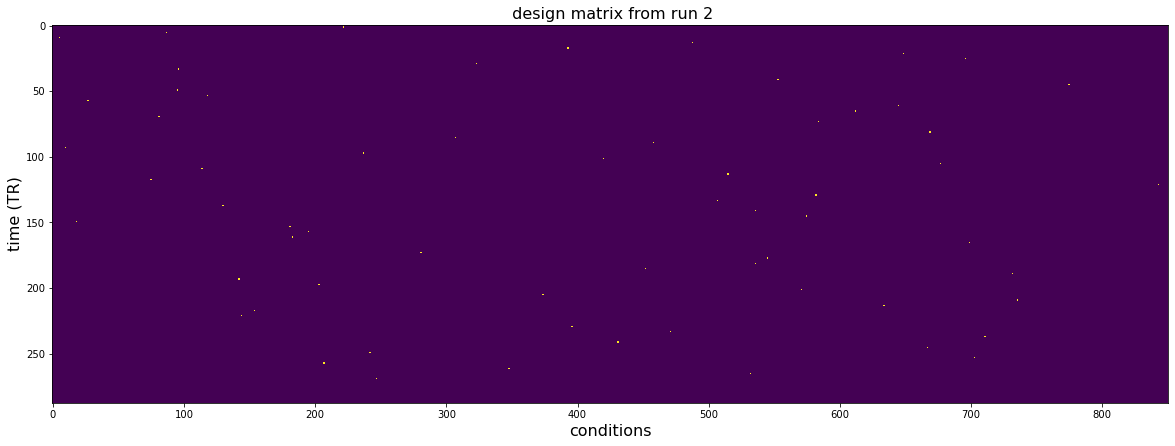

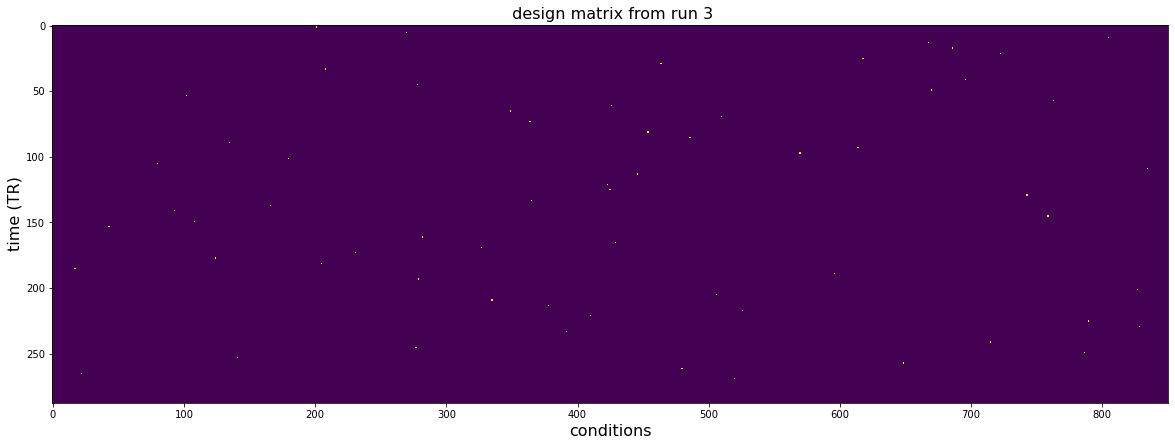

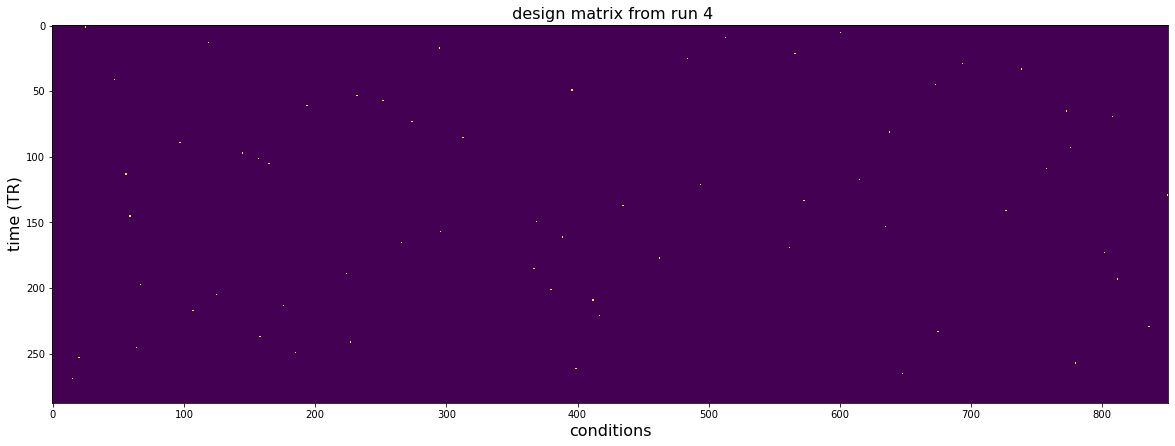

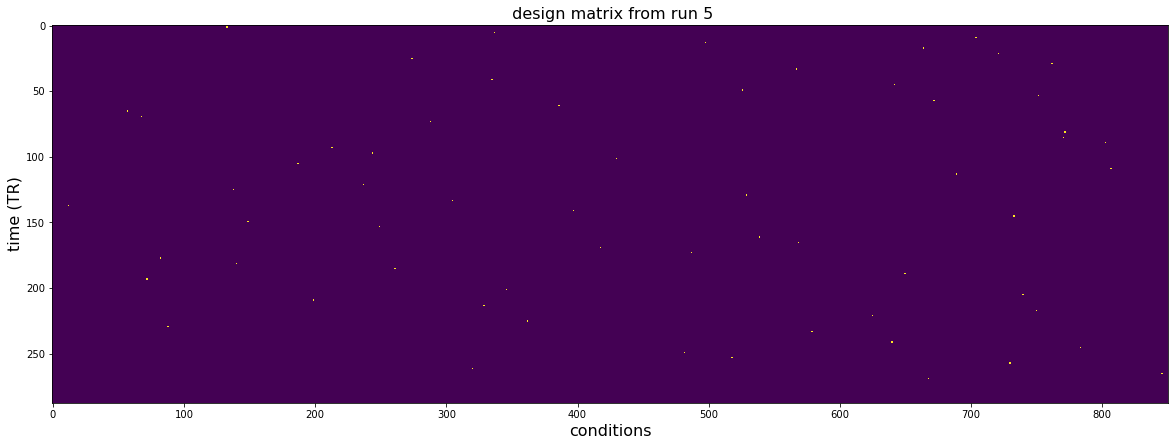

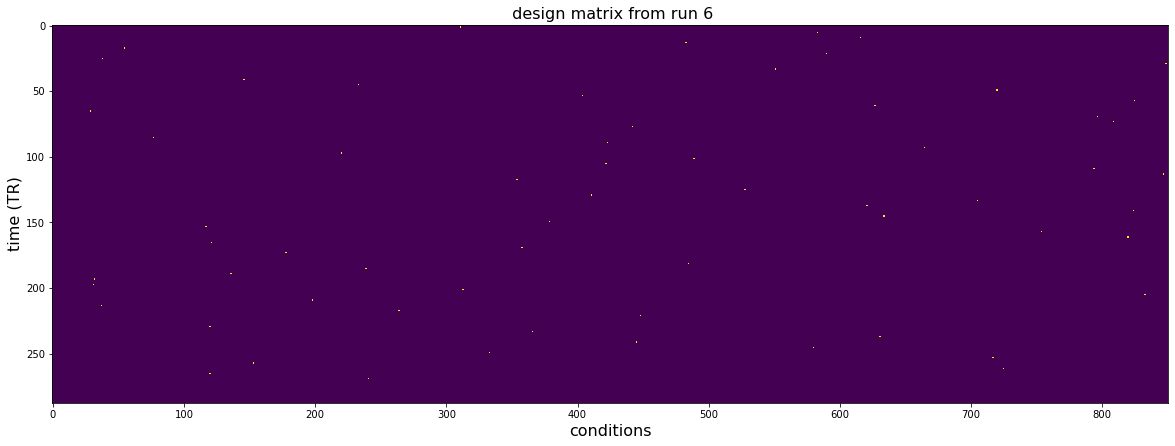

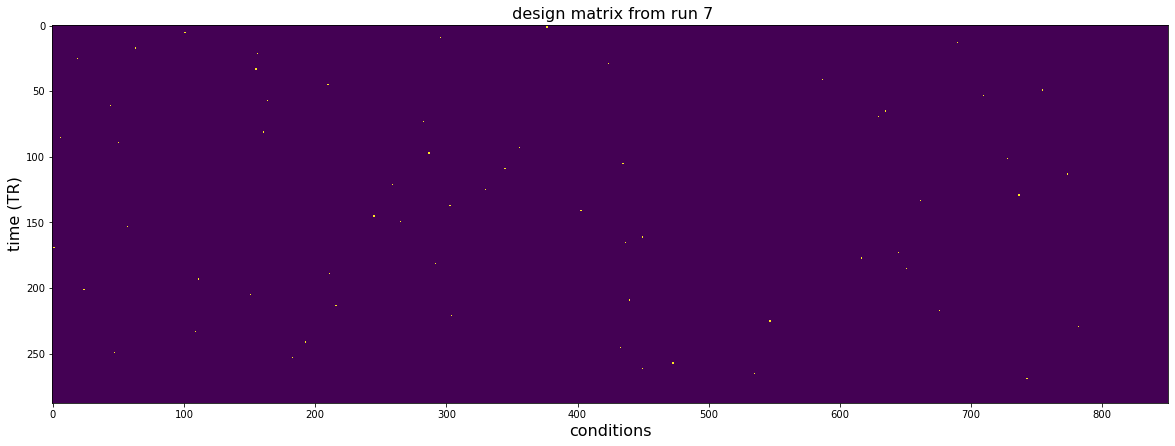

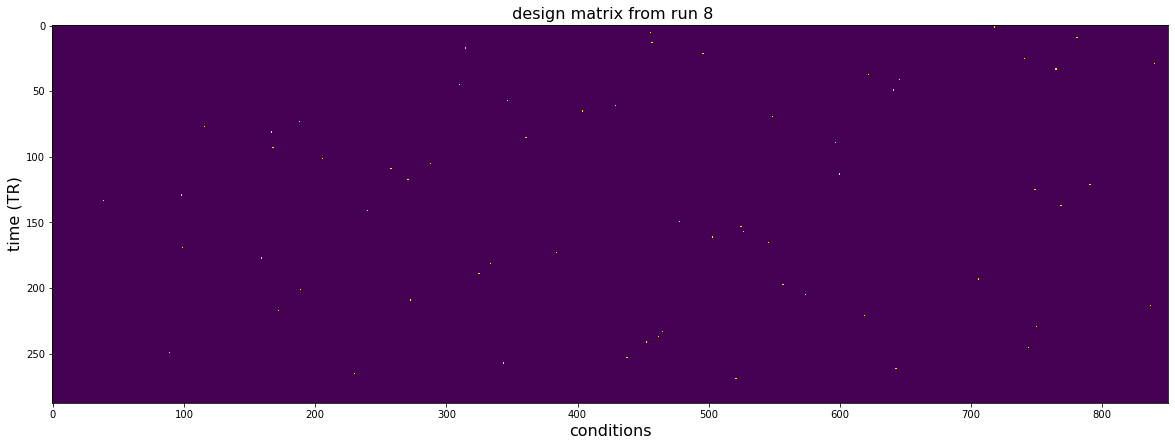

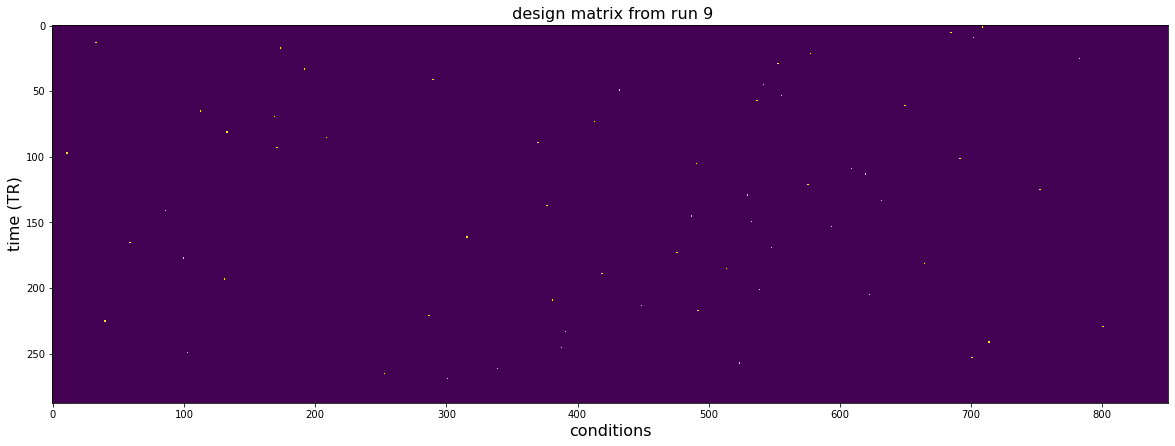

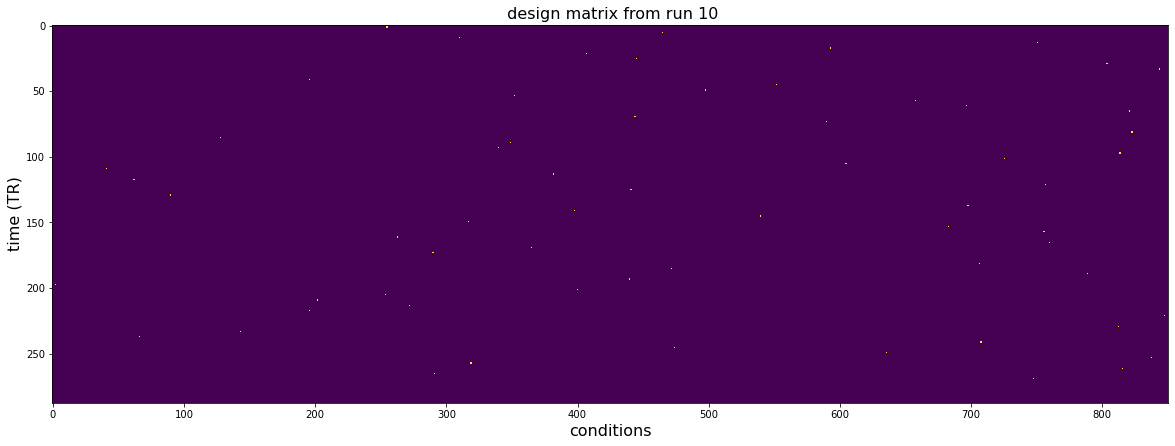

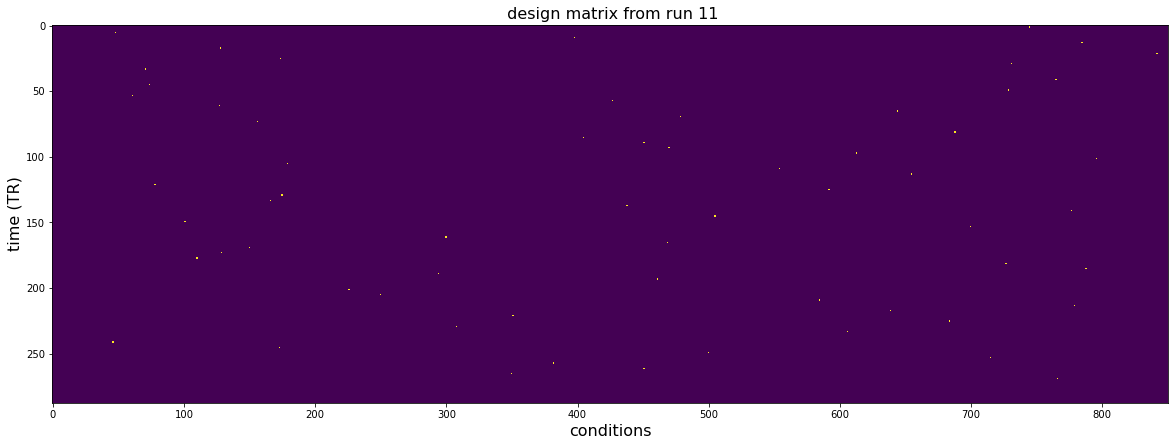

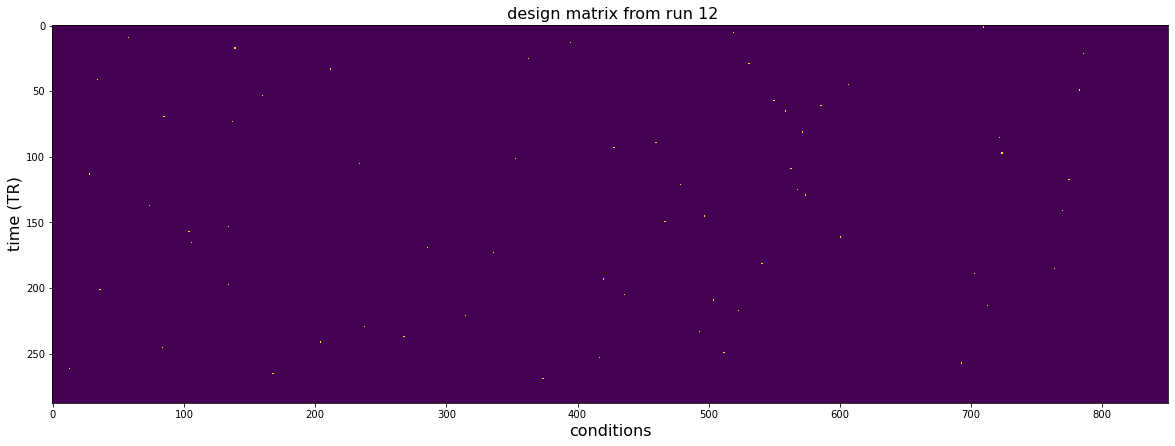

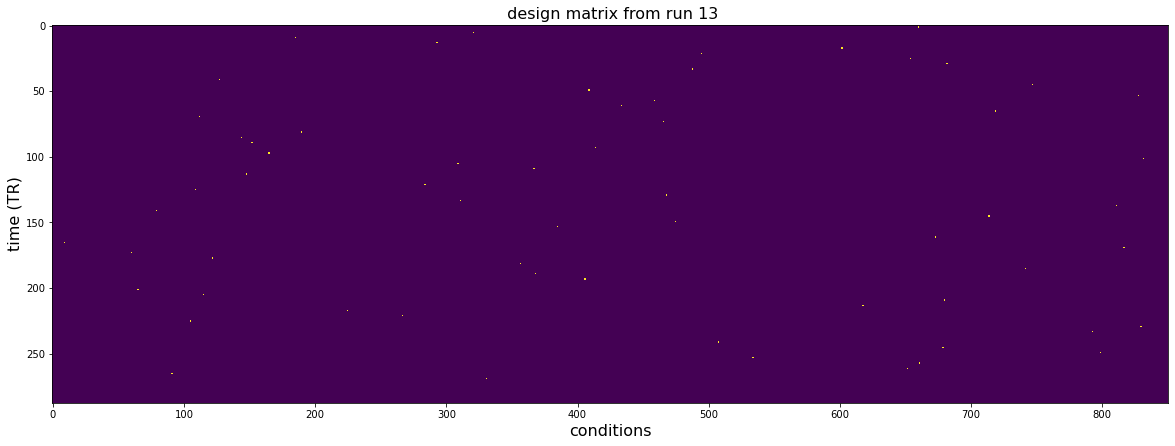

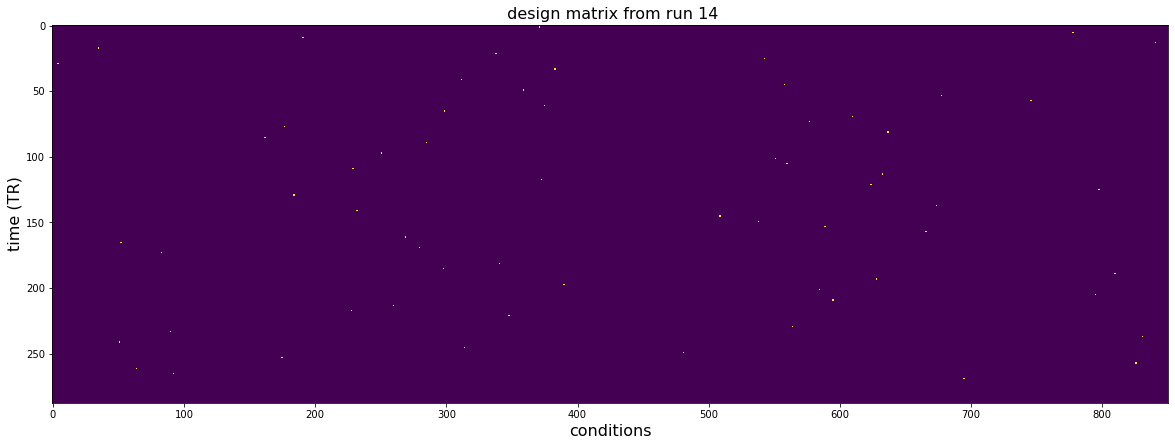

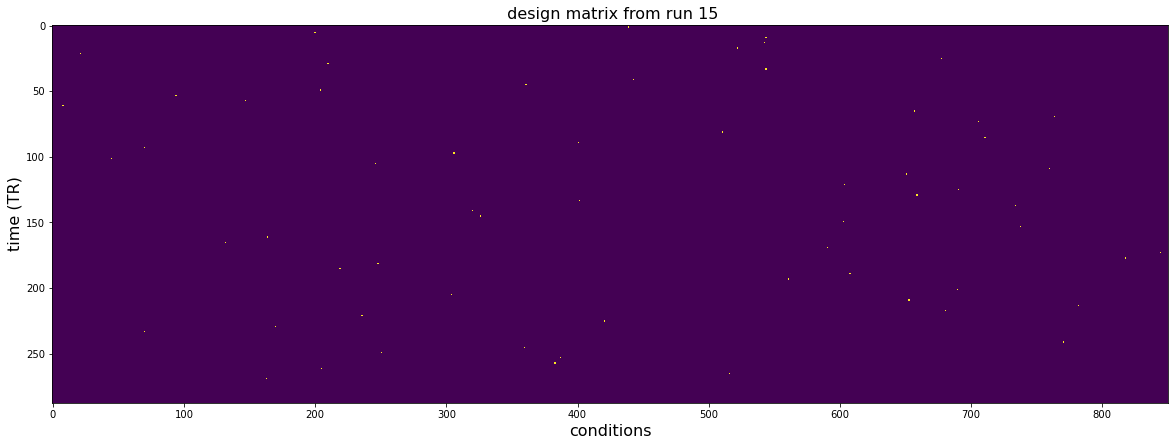

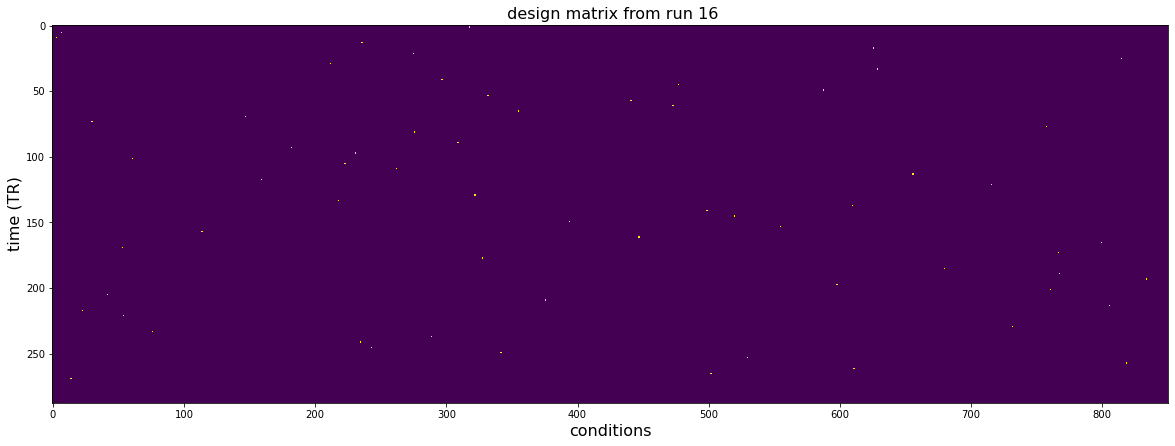

In [23]:
# Plot design matrix for each run
for run in range(n_runs):
    plt.figure(figsize=(20,20))
    plt.imshow(design[run][:,:],interpolation='none')
    plt.title(' design matrix from run %i' %(run+1), fontsize=16)
    plt.xlabel('conditions',fontsize=16)
    plt.ylabel('time (TR)',fontsize=16) 

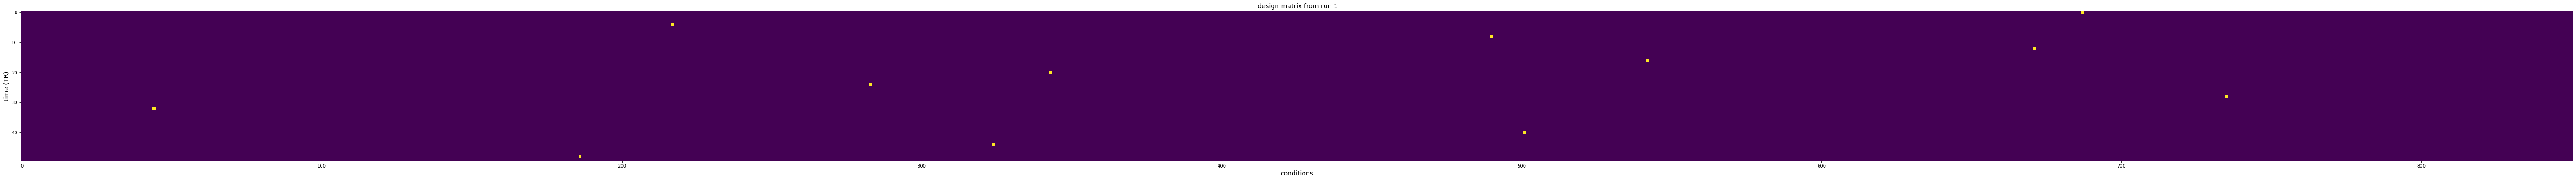

In [28]:
# Plot design matrix for each run
for run in range(1):
    plt.figure(figsize=(100,100))
    plt.imshow(design[run][:50,:],interpolation='none')
    plt.title(' design matrix from run %i' %(run+1), fontsize=14)
    plt.xlabel('conditions',fontsize=14)
    plt.ylabel('time (TR)',fontsize=14) 

## Run GLMsingle with default parameters to estimate single-trial betas

In [25]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [29]:
# create a directory for saving GLMsingle outputs
#outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
outputdir_glmsingle = join(homedir,'derivatives','glmsingle', sub, 'glmsingle')
figuredir_glmsingle = join(homedir,'derivatives','glmsingle', 'figures', sub)
os.makedirs(outputdir_glmsingle,exist_ok=True)
os.makedirs(figuredir_glmsingle,exist_ok=True)

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [0,0,0,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
#opt['wanthdf5'] = 1

# set sessionindicator since runs come from two different scan sessions
#session_indicator = np.array(session_indicator).astype(int).reshape(1,n_runs)
#opt['sessionindicator'] = session_indicator

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1722852960.9739487,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [0, 0, 0, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [30]:
print('shape of data before running GLMsingle:')
print(data_upsampled[0].shape)
print('shape of design matrix:')
print(design[0].shape)

shape of data before running GLMsingle:
(165240, 288)
shape of design matrix:
(288, 851)


In [31]:
# Try running with brainexclude=avg_mask
# if it crashes, then increase max to 1,500,000

# this example saves output files to the outputdir folder
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

#if not exists(outputdir_glmsingle):
if run_glmsingle == 1:
    print('saving outputs to', outputdir_glmsingle)
    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle,
       figuredir=figuredir_glmsingle
       )
    
    # save results in memory to npz
    np.savez(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'), **results_glmsingle['typea'])
    np.savez(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'), **results_glmsingle['typeb'])
    np.savez(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'), **results_glmsingle['typec'])
    np.savez(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'), **results_glmsingle['typed'])
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
elif run_glmsingle == 0:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    # takes about 2 minutes to load
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm = dict()
        results_intm['typea'] = h5py.File(join(outputdir_glmsingle,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm['typeb'] = h5py.File(join(outputdir_glmsingle,'TYPEB_FITHRF.hdf5'), 'r')
        results_intm['typec'] = h5py.File(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.hdf5'), 'r')
        results_intm['typed'] = h5py.File(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.hdf5'), 'r')
        
        model_types = ['typea', 'typeb', 'typec', 'typed']
        for model in range(len(model_types)):
            results_glmsingle[model_types[model]] = dict()
            plot_fields = list(results_intm[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_glmsingle[model_types[model]][plot_fields[i]] = results_intm[model_types[model]].get(plot_fields[i]).value
    
    else: #load npy files
        #results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        #results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
        #results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()
        results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'))
        results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'))
        results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'))
        results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'))
        
elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/glmsingle
	elapsed time:  00:00:00


## Summary of important outputs

the outputs of GLMsingle are formally documented in its header. here, we highlight a few of the more important outputs:

* R2 -> is model accuracy expressed in terms of R^2 (percentage).

* betasmd -> is the full set of single-trial beta weights (X x Y x Z x TRIALS). beta weights are arranged in chronological order.

* HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered with getcanonicalHRFlibrary(stimdur,tr)

* FRACvalue -> is the fractional ridge regression regularization level chosen for each voxel. values closer to 1 mean less regularization.

In [32]:
# GLMsingle output is in 2D format (voxels,samples)
# we need to unmask the data to get it back into 3D/4D format:
# X = nilearn.masking.unmask(results_glmsingle['typeb']['HRFindex'], avg_mask)
# X_hrf = X.get_fdata()

In [33]:
# results_out = {
#                     'onoffR2': np.reshape(onoffR2, [nx, ny, nz]),
#                     'meanvol': np.reshape(meanvol, [nx, ny, nz]),
#                     'betasmd': np.reshape(betasmd, [nx, ny, nz])
#                     }

In [34]:
results_glmsingle['typeb']

In [35]:
# convert everything back to 3D/4D array format
model_types = ['typea','typeb','typec','typed']

results_glmsingle_3D = dict()

for model in range(len(model_types)):
    results_glmsingle_3D[model_types[model]] = dict()
    
    #plot_fields = list(results_glmsingle[model_types[model]].keys())
    #print(model, plot_fields)
    
    if model == 0: #type A
        plot_fields = ['betasmd','meanvol','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex', 'FitHRFR2']
    elif model == 2: #type C
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex']
    elif model == 3: #type D
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex','FRACvalue']
    print(model_types[model])
    
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_glmsingle[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_glmsingle[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_glmsingle[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        unmask_data = nilearn.masking.unmask(results_glmsingle[model_types[model]][plot_fields[i]].T, avg_mask)
        # unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        results_glmsingle_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_glmsingle_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
original shape: (165240, 1)
2D shape: (1, 165240)
shape of unmasked data: (72, 94, 71, 1)

meanvol
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

onoffR2
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

typeb
betasmd
original shape: (165240, 1000)
2D shape: (1000, 165240)
shape of unmasked data: (72, 94, 71, 1000)

meanvol
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

R2
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

HRFindex
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

FitHRFR2
original shape: (165240, 20)
2D shape: (20, 165240)
shape of unmasked data: (72, 94, 71, 20)

typec
betasmd
original shape: (165240, 1000)
2D shape: (1000, 165240)
shape of unmasked data: (72, 94, 71, 1000)

meanvol
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

R2
o

## Plot a slice of brain showing GLMsingle outputs

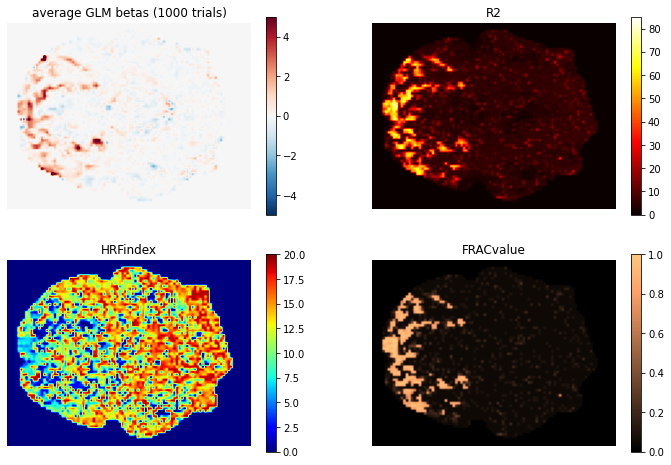

In [36]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# choose a slice
#z=round(xyz[2]/3)
z=29

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
#plot_fields = ['betasmd']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
        titlestr = 'average GLM betas (1000 trials)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

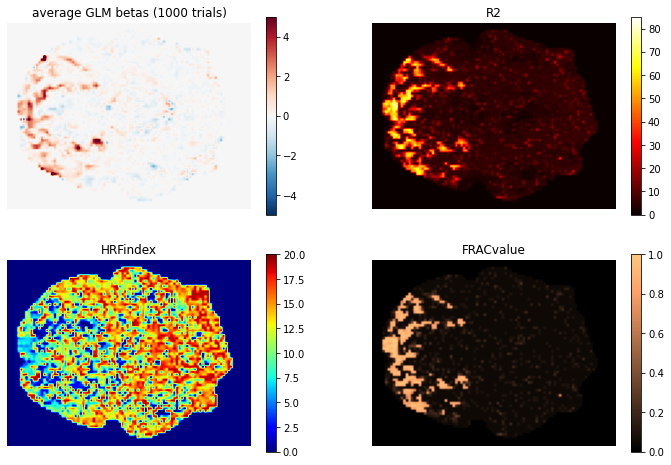

In [33]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# choose a slice
#z=round(xyz[2]/3)
z=29

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
#plot_fields = ['betasmd']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
        titlestr = 'average GLM betas (1000 trials)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

## Run a baseline GLM to compare with GLMsingle outputs

In [42]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(homedir,'derivatives','glmsingle', sub, 'glmbaseline')
os.makedirs(outputdir_baseline,exist_ok=True)

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed

opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1722852960.9739487,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wanthdf5': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [43]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
#if not exists(outputdir_baseline):
if run_glmbaseline == 1:
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
    # save results in memory to npz
    np.savez(join(outputdir_baseline,'TYPEA_ONOFF.npz'), **results_assumehrf['typea'])
    np.savez(join(outputdir_baseline,'TYPEB_FITHRF.npz'), **results_assumehrf['typeb'])

elif run_glmbaseline == 0:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_baseline}')
    
    results_assumehrf = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm2 = dict()
        results_intm2['typea'] = h5py.File(join(outputdir_baseline,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm2['typeb'] = h5py.File(join(outputdir_baseline,'TYPEB_FITHRF.hdf5'), 'r')
        
        model_types = ['typea', 'typeb']
        for model in range(len(model_types)):
            results_assumehrf[model_types[model]] = dict()
            plot_fields = list(results_intm2[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_assumehrf[model_types[model]][plot_fields[i]] = results_intm2[model_types[model]].get(plot_fields[i]).value
    else:
        #results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npz'))
        results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npz'))
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/sub-001/glmbaseline
	elapsed time:  00:00:00


In [44]:
# convert back to 3D/4D array format
model_types = ['typea','typeb']

results_assumehrf_3D = dict()

for model in range(len(model_types)):
    results_assumehrf_3D[model_types[model]] = dict()
    if model == 0: #type A
        plot_fields = ['betasmd','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','R2','HRFindex']
    print(model_types[model])
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_assumehrf[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_assumehrf[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_assumehrf[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        # unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        unmask_data = nilearn.masking.unmask(results_assumehrf[model_types[model]][plot_fields[i]].T, avg_mask)
        results_assumehrf_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_assumehrf_3D[model_types[model]][plot_fields[i]].shape)
        print('')

typea
betasmd
original shape: (165240, 1)
2D shape: (1, 165240)
shape of unmasked data: (72, 94, 71, 1)

onoffR2
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

typeb
betasmd
original shape: (165240, 1000)
2D shape: (1000, 165240)
shape of unmasked data: (72, 94, 71, 1000)

R2
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)

HRFindex
original shape: (165240,)
2D shape: (165240, 1)
shape of unmasked data: (72, 94, 71)



In [45]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf_3D['typeb']['betasmd']#.reshape(xyz + (1000,))
models['fithrf'] = results_glmsingle_3D['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle_3D['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle_3D['typed']['betasmd']

## Get indices of repeated conditions to use for reliability calculations

To compare the results of different GLMs we are going to calculate the voxel-wise split-half reliablity for each model. Reliability values reflect a correlation between beta weights for repeated presentations of the same conditions. In short, we are going to check how reliable/reproducible are the single trial responses to repeated conditions estimated with each GLM type.

In the code below, we are attempting to locate the indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that correspond to repeated images.

In [46]:
run_reliability = 1

In [47]:
if run_reliability == 1:
    
    # consolidate design matrices
    designALL = np.concatenate(design,axis=0)
    print('designALL shape (TRs, conditions):', designALL.shape)

    # construct a vector containing 0-indexed condition numbers in chronological order
    corder = []
    for p in range(designALL.shape[0]):
        if np.any(designALL[p]):
            corder.append(np.argwhere(designALL[p])[0,0])

    corder = np.array(corder)
    
    # let's take a look at the first few entries
    print(corder[:3])
    
    # note that [374 496 7] means that the first stimulus trial involved
    # presentation of the 374th condition (zero-indexed), the second stimulus trial 
    # involved presentation of the 496th condition, and so on.

designALL shape (TRs, conditions): (4608, 851)
[687 217 490]


In [48]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

if run_reliability == 1:
    
    repindices = [] # 2 x images containing stimulus trial indices.

    # the first row refers to the first presentation; the second row refers to
    # the second presentation.
    for p in range(designALL.shape[1]): # loop over every condition

        temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
        #print(len(temp)) #vio condition should have 11 As, nonvio should have 9 As
        
        # only add repeated conditions to repindices
        if len(temp) >= 2:
            repindices.append([temp[0], temp[1]]) # note that for now we only look at first 2 repetitions

    repindices = np.vstack(np.array(repindices)).T
    print(repindices.shape, '(repetitions, condition)')

(2, 150) (repetitions, condition)


In [49]:
if run_reliability == 1:
    # let's take a look at a few entries
    print(repindices[:,:3])
    
    # notice that the first condition is presented on the 216th zero-indexed 
    # stimulus trial and the 485th stimulus trial, the second condition is presented on the
    # 217th and 620st stimulus trials, and so on.
    
    print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the

[[  8 196  23]
 [389 431 395]]
there are 150 repeated conditions in the experiment


## Compute median split-half reliabilty within the ROI for each beta version

In [50]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them
if run_reliability == 1:
    
    vox_reliabilities = [] # output variable for reliability values

    modelnames = list(models.keys())#[1:]
    print(modelnames)

    # for each beta version...
    for m in range(len(modelnames)):

        print(f'computing reliability for beta version: {modelnames[m]}')
        time.sleep(1)

        # get the repeated-condition GLM betas using our repindices variable
        betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        # betas = models[modelnames[m]]['betasmd'][:,None,None,:][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        x,y,z = betas.shape[:3] 

        rels = np.full((x,y,z),np.nan)

        # loop through voxels in the 3D volume...
        for xx in tqdm(range(x)):
            for yy in range(y):
                for zz in range(z):

                    # reliability at a given voxel is pearson correlation between response profiles from first and 
                    # second image presentations (dim = 136 conditions)
                    rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                                 betas[xx,yy,zz,1])[1,0]

        vox_reliabilities.append(rels)

['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
computing reliability for beta version: assumehrf


100%|█████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:54<00:00,  1.33it/s]


computing reliability for beta version: fithrf


100%|█████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:54<00:00,  1.32it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|█████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:54<00:00,  1.33it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|█████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:54<00:00,  1.32it/s]


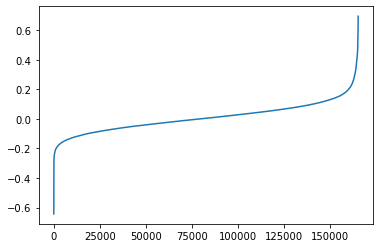

85732
79508


In [58]:
a = vox_reliabilities[-1]
a = a[~np.isnan(a)]
plt.plot(np.sort(a))
plt.show()
print(len(a[a>0]))
print(len(a[a<0]))

In [44]:
# load mask defining liberal visual cortex ROI
mask = 'nsdgeneral'
roi = []
mask_file=maskdir + '/%s_%s.nii.gz' % (sub,mask)
print(mask_file)
mask_data=nib.load(mask_file)
roi=mask_data.get_fdata()

assert mask_data.header.get_zooms() == epi_dimsize[:3]
assert mask_data.affine.all() == epi_data.affine.all()
print('roi shape:', roi.shape)
print(np.min(roi), np.max(roi))

roi = roi.astype(float)
# convert voxels outside ROI to nan for overlay plotting
roi[roi==0] = np.nan 
print(np.nanmin(roi), np.nanmax(roi))
print(roi.shape)

roi = roi.flatten()
brain_mask = avg_mask.get_fdata().flatten()
roi = roi[brain_mask.astype(np.bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(np.bool)
print(roi.shape)

/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/masks/sub-001/sub-001_nsdgeneral.nii.gz
roi shape: (72, 94, 71)
0.0 1.0
1.0 1.0
(72, 94, 71)
(165240,)


In [45]:
# Save voxel reliabilities in NSDgeneral ROI
if run_reliability == 1:
    vox_rel_nsdgeneral = []
    for vr in vox_reliabilities:
        vox_rel_nsdgeneral.append(vr[avg_mask.get_fdata()==1][roi==True])
        
    savedir=f'/jukebox/norman/pscotti/rtmindeye/data/bids/derivatives/glmsingle/{sub}/'
    np.save(join(savedir,'voxel_reliabilities_NSDgeneral.npy'), vox_rel_nsdgeneral)

## Assess change in reliability yielded by GLMsingle

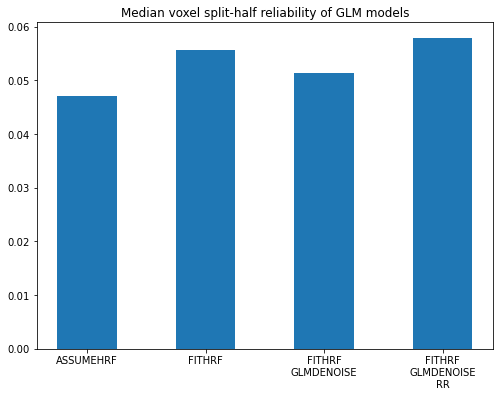

In [46]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph
if run_reliability == 1:
    comparison = []
    for vr in vox_reliabilities:
        # comparison.append(np.nanmedian(vr)) 
        comparison.append(np.nanmedian(vr[avg_mask.get_fdata()==1][roi==True]))

    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.bar(np.arange(len(comparison)),comparison,width=0.5)
    plt.title('Median voxel split-half reliability of GLM models')
    plt.xticks(np.arange(4),np.array(['ASSUMEHRF','FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']))
    #plt.ylim([0.1,0.2])